In [1]:
# Data processing
import iris
import iris.analysis
import iris.coord_categorisation
import warnings
warnings.filterwarnings('ignore', module='iris')
import numpy as np
from pathlib import Path
from scipy import stats
# Visualization
import cartopy.util
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import FuncFormatter
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)
    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
def m2km(x, pos):
    '''Convert meters to kilometers when plotting axis labels'''
    return int(x*1e-3)
plt.rcParams['mathtext.default'] = 'regular'
savefig = False
# Constants
M_air = 28.97 # dry air [kg]
coeff_var = (M_air/48.00)*1e9 # convert mass mixing ratio to volume mixing ratio
str_var = '$O_3$'
str_djf = 'DJF'; str_mam = 'MAM'; str_jja = 'JJA'; str_son = 'SON'

In [2]:
# Read data
base = 'xnvtc'; sens = 'xnvth'; base_plt = 'CheT orig'; sens_plt = 'CheT revised'
path_to_ukca = Path('../data')
base = iris.load_cube(str(path_to_ukca / base / f'{base}_o3.nc'))*coeff_var
sens = iris.load_cube(str(path_to_ukca / sens / f'{sens}_o3.nc'))*coeff_var
# Path to figures
path_to_figs = Path('../../../results') / 'deltasign'
path_to_figs.mkdir(exist_ok=True)

In [3]:
# Add new coordinates
iris.coord_categorisation.add_season(base, 'time', name='season')
iris.coord_categorisation.add_season(sens, 'time', name='season')
iris.coord_categorisation.add_season_year(base, 'time', name='year')
iris.coord_categorisation.add_season_year(sens, 'time', name='year')
# # Replace last January's year with first February's year
# base.coord('year').points = np.array([2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006,
#                                       2007, 2007, 2007, 2007, 2007, 2007, 2007, 2007, 2007, 2007, 2007,
#                                       2007, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008,
#                                       2008, 2008, 2006])
# sens.coord('year').points = base.coord('year').points

#### Zonal seasonal means

1. Perform the Shapiro-Wilk test for normality. scipy docs: The Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution. Wikipedia: if the p-value is less than the chosen alpha level, then the null hypothesis is rejected and there is evidence that the data tested are not normally distributed. On the other hand, if the p-value is greater than the chosen alpha level, then the null hypothesis that the data came from a normally distributed population can not be rejected. I.e. if p<0.05, data is not normal, if p>0.05, data is normal.
2. Perform paired samples t-test (https://pythonfordatascience.org/paired-samples-t-test-python/) if is data is normally distributed, or Wilcoxon signed-rank test (https://pythonfordatascience.org/wilcoxon-sign-ranked-test-python/) if data is not normally distributed.
2a. scipy docs: Paired samples t-test is a two-sided test for the null hypothesis that 2 related or repeated samples have identical average (expected) values. If we observe a large p-value, for example greater than 0.05 or 0.1 then we cannot reject the null hypothesis of identical average scores. If the p-value is smaller than the threshold, e.g. 1%, 5% or 10%, then we reject the null hypothesis of equal averages.
2b. scipy docs: The Wilcoxon signed-rank test tests the null hypothesis that two related paired samples come from the same distribution. In particular, it tests whether the distribution of the differences x - y is symmetric about zero. It is a non-parametric version of the paired T-test. Because the normal approximation is used for the calculations, the samples used should be large. A typical rule is to require that n > 20. Currently my n=10...
3. Control false discovery rate. See https://en.wikipedia.org/wiki/False_discovery_rate, https://fabienmaussion.info/2017/01/30/trendy-triangles-fdr/, https://www.statisticshowto.datasciencecentral.com/false-discovery-rate/, https://www.statisticshowto.datasciencecentral.com/multiple-testing-problem/

Explanation of the difference between using one sample and paired samples tests: http://benalexkeen.com/comparative-statistics-in-python-using-scipy/

In [4]:
# Calculate zonal means for each month
base_znl_mean = base.collapsed('longitude', iris.analysis.MEAN)
sens_znl_mean = sens.collapsed('longitude', iris.analysis.MEAN)
# Extract time series of zonal seasonal means
base_znl_djf = base_znl_mean.extract(iris.Constraint(season='djf')).aggregated_by(['year', 'season'], iris.analysis.MEAN)
sens_znl_djf = sens_znl_mean.extract(iris.Constraint(season='djf')).aggregated_by(['year', 'season'], iris.analysis.MEAN)
base_znl_mam = base_znl_mean.extract(iris.Constraint(season='mam')).aggregated_by(['year', 'season'], iris.analysis.MEAN)
sens_znl_mam = sens_znl_mean.extract(iris.Constraint(season='mam')).aggregated_by(['year', 'season'], iris.analysis.MEAN)
base_znl_jja = base_znl_mean.extract(iris.Constraint(season='jja')).aggregated_by(['year', 'season'], iris.analysis.MEAN)
sens_znl_jja = sens_znl_mean.extract(iris.Constraint(season='jja')).aggregated_by(['year', 'season'], iris.analysis.MEAN)
base_znl_son = base_znl_mean.extract(iris.Constraint(season='son')).aggregated_by(['year', 'season'], iris.analysis.MEAN)
sens_znl_son = sens_znl_mean.extract(iris.Constraint(season='son')).aggregated_by(['year', 'season'], iris.analysis.MEAN)
# Check if zonal seasonal mean differences between two experiments are normally distributed using the Shapiro–Wilk test
nlevs = base.coord('level_height').shape[0]
nlats = base.coord('latitude').shape[0]
shapiro_znl_djf_p = np.empty([nlevs,nlats])
shapiro_znl_mam_p = np.empty([nlevs,nlats])
shapiro_znl_jja_p = np.empty([nlevs,nlats])
shapiro_znl_son_p = np.empty([nlevs,nlats])
for i, lev in enumerate(base.coord('level_height').points):
    for j, lat in enumerate(base.coord('latitude').points):
        shapiro_znl_djf_p[i,j] = stats.shapiro(base_znl_djf.data[:,i,j] - sens_znl_djf.data[:,i,j])[1]
        shapiro_znl_mam_p[i,j] = stats.shapiro(base_znl_mam.data[:,i,j] - sens_znl_mam.data[:,i,j])[1]
        shapiro_znl_jja_p[i,j] = stats.shapiro(base_znl_jja.data[:,i,j] - sens_znl_jja.data[:,i,j])[1]
        shapiro_znl_son_p[i,j] = stats.shapiro(base_znl_son.data[:,i,j] - sens_znl_son.data[:,i,j])[1]
# See if zonal seasonal mean differences between two experiments are statitically significant using
# (a) paired sample t-test if data is normally distributed, and
# (b) Wilcoxon signed-rank test if data is not normally distributed
znl_djf_p = np.empty([nlevs,nlats])
znl_mam_p = np.empty([nlevs,nlats])
znl_jja_p = np.empty([nlevs,nlats])
znl_son_p = np.empty([nlevs,nlats])
for i, lev in enumerate(base.coord('level_height').points):
    for j, lat in enumerate(base.coord('latitude').points):
        if shapiro_znl_djf_p[i,j] > 0.05:
            znl_djf_p[i,j] = stats.ttest_rel(base_znl_djf.data[:,i,j], sens_znl_djf.data[:,i,j])[1]
        else: 
            znl_djf_p[i,j] = stats.wilcoxon(base_znl_djf.data[:,i,j], sens_znl_djf.data[:,i,j])[1]
        if shapiro_znl_mam_p[i,j] > 0.05:
            znl_mam_p[i,j] = stats.ttest_rel(base_znl_mam.data[:,i,j], sens_znl_mam.data[:,i,j])[1]
        else:
            znl_mam_p[i,j] = stats.wilcoxon(base_znl_mam.data[:,i,j], sens_znl_mam.data[:,i,j])[1]
        if shapiro_znl_jja_p[i,j] > 0.05:
            znl_jja_p[i,j] = stats.ttest_rel(base_znl_jja.data[:,i,j], sens_znl_jja.data[:,i,j])[1]
        else:
            znl_jja_p[i,j] = stats.wilcoxon(base_znl_jja.data[:,i,j], sens_znl_jja.data[:,i,j])[1]
        if shapiro_znl_son_p[i,j] > 0.05:
            znl_son_p[i,j] = stats.ttest_rel(base_znl_son.data[:,i,j], sens_znl_son.data[:,i,j])[1]
        else:
            znl_son_p[i,j] = stats.wilcoxon(base_znl_son.data[:,i,j], sens_znl_son.data[:,i,j])[1]
# Calculate zonal seasonal means differences
base_znl_djf_mean = base_znl_djf.collapsed('year', iris.analysis.MEAN)
base_znl_mam_mean = base_znl_mam.collapsed('year', iris.analysis.MEAN)
base_znl_jja_mean = base_znl_jja.collapsed('year', iris.analysis.MEAN)
base_znl_son_mean = base_znl_son.collapsed('year', iris.analysis.MEAN)
sens_znl_djf_mean = sens_znl_djf.collapsed('year', iris.analysis.MEAN)
sens_znl_mam_mean = sens_znl_mam.collapsed('year', iris.analysis.MEAN)
sens_znl_jja_mean = sens_znl_jja.collapsed('year', iris.analysis.MEAN)
sens_znl_son_mean = sens_znl_son.collapsed('year', iris.analysis.MEAN)
znl_djf_diff = sens_znl_djf_mean - base_znl_djf_mean
znl_mam_diff = sens_znl_mam_mean - base_znl_mam_mean
znl_jja_diff = sens_znl_jja_mean - base_znl_jja_mean
znl_son_diff = sens_znl_son_mean - base_znl_son_mean

In [5]:
def fdr_threshold(pvalues, alpha=0.05*2):
    '''Compute the FDR threshod after Wilks (2016). Credit to https://fabienmaussion.info/2017/01/30/trendy-triangles-fdr/'''
    p = np.sort(np.asarray(pvalues).flatten())
    n = len(p)
    return np.max(np.where(p <= np.arange(1, n+1) / n * alpha, p, 0))

In [6]:
# Turn FDR on or off
print(fdr_threshold(znl_djf_p), fdr_threshold(znl_mam_p), fdr_threshold(znl_jja_p), fdr_threshold(znl_son_p))
fdr_znl = True

0.0 0.0 0.0 0.0


In [7]:
# Zonal means plotting parameters
if fdr_znl:
    def stipple_zonal(cube, pval_arr):
        '''Stipple areas where p-values are lower than FDR threshold (statistically significant). 
        Inspired by https://groups.google.com/forum/#!topic/scitools-iris/Xm2IhQ6YKQA'''
        xOrg = cube.coord('latitude').points 
        yOrg = cube.coord('level_height').points
        nlon = len(xOrg) 
        nlat = len(yOrg) 
        xData = np.reshape( np.tile(xOrg, nlat), pval_arr.shape ) 
        yData = np.reshape( np.repeat(yOrg, nlon), pval_arr.shape ) 
        thresh = fdr_threshold(pval_arr)
        sigPoints = pval_arr < thresh 
        xPoints = xData[sigPoints]
        yPoints = yData[sigPoints]
        return (xPoints, yPoints)
else:
    def stipple_zonal(cube, pval_arr, thresh=0.05):
        '''Stipple areas where p-values are lower than 0.05 (statistically significant). 
        Inspired by https://groups.google.com/forum/#!topic/scitools-iris/Xm2IhQ6YKQA'''
        xOrg = cube.coord('latitude').points 
        yOrg = cube.coord('level_height').points
        nlon = len(xOrg) 
        nlat = len(yOrg) 
        xData = np.reshape( np.tile(xOrg, nlat), pval_arr.shape ) 
        yData = np.reshape( np.repeat(yOrg, nlon), pval_arr.shape ) 
        sigPoints = pval_arr < thresh 
        xPoints = xData[sigPoints]
        yPoints = yData[sigPoints]
        return (xPoints, yPoints)
# Find max zonal seasonal mean
print(max(np.max(base_znl_djf_mean.data), np.max(sens_znl_djf_mean.data)))
print(max(np.max(base_znl_mam_mean.data), np.max(sens_znl_mam_mean.data)))
print(max(np.max(base_znl_jja_mean.data), np.max(sens_znl_jja_mean.data)))
print(max(np.max(base_znl_son_mean.data), np.max(sens_znl_son_mean.data)))
znl_mean_cf_kwargs = dict(levels=np.arange(0,13000,1000))
znl_mean_pc_kwargs = dict(cmap='RdBu_r')
znl_mean_cr_kwargs = dict(levels=[0,5,10], cmap='Greys')
znl_pval_kwargs = dict(s=5, c='k', marker='.', alpha=1)

11592.38271484375
11402.914013671874
11363.12755533854
11299.21944986979


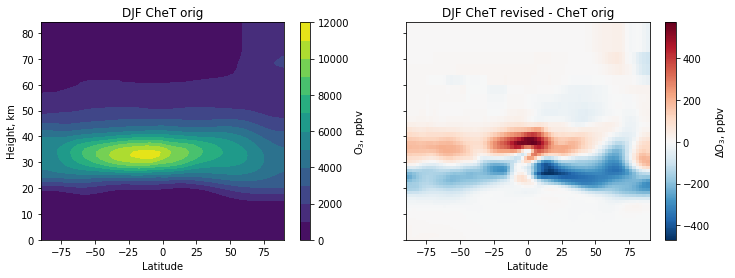

In [8]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4), facecolor='w', sharex=True, sharey=True)
p00 = ax[0].contourf(base.coord('latitude').points, base.coord('level_height').points, base_znl_djf_mean.data, **znl_mean_cf_kwargs)
ax[0].set_title(f'{str_djf} {base_plt}')
fig.colorbar(p00, ax=ax[0], label=f'{str_var}, ppbv')
ax[0].set_xlabel('Latitude')
ax[0].set_ylabel('Height, km')
ax[0].yaxis.set_major_formatter(FuncFormatter(m2km))

p01 = ax[1].pcolormesh(base.coord('latitude').points, base.coord('level_height').points, znl_djf_diff.data, norm=MidpointNormalize(midpoint=0.), **znl_mean_pc_kwargs)
# p1 = ax.contour(base.coord('latitude').points, base.coord('level_height').points, znl_djf_diff.data, **znl_mean_cr_kwargs)
ax[1].scatter(*stipple_zonal(znl_djf_diff, znl_djf_p), **znl_pval_kwargs)
ax[1].set_title(f'{str_djf} {sens_plt} - {base_plt}')
fig.colorbar(p01, ax=ax[1], label=f'$\Delta${str_var}, ppbv')
# ax.clabel(p1, inline=1, fmt='%1.0f')
ax[1].set_xlabel('Latitude')
ax[1].margins(x=0, y=0);

if savefig: fig.savefig(path_to_figs / f'znl_seas_mean_{str_djf}.png', bbox_inches='tight')

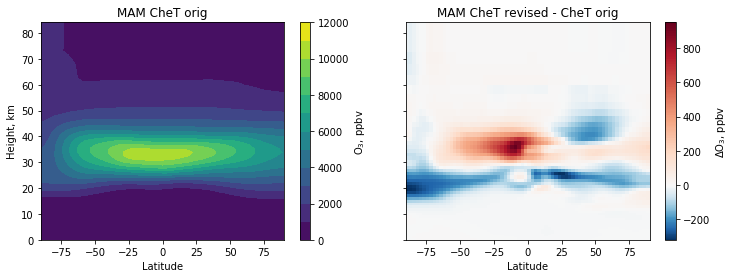

In [9]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4), facecolor='w', sharex=True, sharey=True)
p00 = ax[0].contourf(base.coord('latitude').points, base.coord('level_height').points, base_znl_mam_mean.data, **znl_mean_cf_kwargs)
ax[0].set_title(f'{str_mam} {base_plt}')
fig.colorbar(p00, ax=ax[0], label=f'{str_var}, ppbv')
ax[0].set_xlabel('Latitude')
ax[0].set_ylabel('Height, km')
ax[0].yaxis.set_major_formatter(FuncFormatter(m2km))

p01 = ax[1].pcolormesh(base.coord('latitude').points, base.coord('level_height').points, znl_mam_diff.data, norm=MidpointNormalize(midpoint=0.), **znl_mean_pc_kwargs)
# p1 = ax.contour(base.coord('latitude').points, base.coord('level_height').points, znl_mam_diff.data, **znl_mean_cr_kwargs)
ax[1].scatter(*stipple_zonal(znl_mam_diff, znl_mam_p), **znl_pval_kwargs)
ax[1].set_title(f'{str_mam} {sens_plt} - {base_plt}')
fig.colorbar(p01, ax=ax[1], label=f'$\Delta${str_var}, ppbv')
# ax.clabel(p1, inline=1, fmt='%1.0f')
ax[1].set_xlabel('Latitude')
ax[1].margins(x=0, y=0);

if savefig: fig.savefig(path_to_figs / f'znl_seas_mean_{str_mam}.png', bbox_inches='tight')

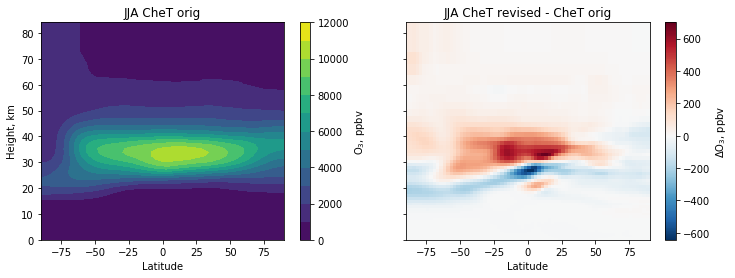

In [10]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4), facecolor='w', sharex=True, sharey=True)
p00 = ax[0].contourf(base.coord('latitude').points, base.coord('level_height').points, base_znl_jja_mean.data, **znl_mean_cf_kwargs)
ax[0].set_title(f'{str_jja} {base_plt}')
fig.colorbar(p00, ax=ax[0], label=f'{str_var}, ppbv')
ax[0].set_xlabel('Latitude')
ax[0].set_ylabel('Height, km')
ax[0].yaxis.set_major_formatter(FuncFormatter(m2km))

p01 = ax[1].pcolormesh(base.coord('latitude').points, base.coord('level_height').points, znl_jja_diff.data, norm=MidpointNormalize(midpoint=0.), **znl_mean_pc_kwargs)
# p1 = ax.contour(base.coord('latitude').points, base.coord('level_height').points, znl_jja_diff.data, **znl_mean_cr_kwargs)
ax[1].scatter(*stipple_zonal(znl_jja_diff, znl_jja_p), **znl_pval_kwargs)
ax[1].set_title(f'{str_jja} {sens_plt} - {base_plt}')
fig.colorbar(p01, ax=ax[1], label=f'$\Delta${str_var}, ppbv')
# ax.clabel(p1, inline=1, fmt='%1.0f')
ax[1].set_xlabel('Latitude')
ax[1].margins(x=0, y=0);

if savefig: fig.savefig(path_to_figs / f'znl_seas_mean_{str_jja}.png', bbox_inches='tight')

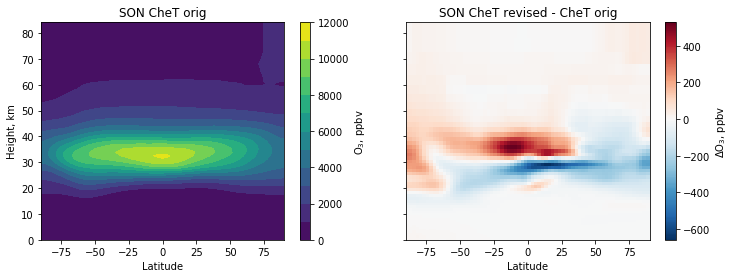

In [11]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4), facecolor='w', sharex=True, sharey=True)
p00 = ax[0].contourf(base.coord('latitude').points, base.coord('level_height').points, base_znl_son_mean.data, **znl_mean_cf_kwargs)
ax[0].set_title(f'{str_son} {base_plt}')
fig.colorbar(p00, ax=ax[0], label=f'{str_var}, ppbv')
ax[0].set_xlabel('Latitude')
ax[0].set_ylabel('Height, km')
ax[0].yaxis.set_major_formatter(FuncFormatter(m2km))

p01 = ax[1].pcolormesh(base.coord('latitude').points, base.coord('level_height').points, znl_son_diff.data, norm=MidpointNormalize(midpoint=0.), **znl_mean_pc_kwargs)
# p1 = ax.contour(base.coord('latitude').points, base.coord('level_height').points, znl_son_diff.data, **znl_mean_cr_kwargs)
ax[1].scatter(*stipple_zonal(znl_son_diff, znl_son_p), **znl_pval_kwargs)
ax[1].set_title(f'{str_son} {sens_plt} - {base_plt}')
fig.colorbar(p01, ax=ax[1], label=f'$\Delta${str_var}, ppbv')
# ax.clabel(p1, inline=1, fmt='%1.0f')
ax[1].set_xlabel('Latitude')
ax[1].margins(x=0, y=0);

if savefig: fig.savefig(path_to_figs / f'znl_seas_mean_{str_son}.png', bbox_inches='tight')

#### Surface seasonal means

In [12]:
# Extract time series of surface seasonal means
base_srf_djf = base.extract(iris.Constraint(season='djf')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0,...]
sens_srf_djf = sens.extract(iris.Constraint(season='djf')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0,...]
base_srf_mam = base.extract(iris.Constraint(season='mam')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0,...]
sens_srf_mam = sens.extract(iris.Constraint(season='mam')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0,...]
base_srf_jja = base.extract(iris.Constraint(season='jja')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0,...]
sens_srf_jja = sens.extract(iris.Constraint(season='jja')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0,...]
base_srf_son = base.extract(iris.Constraint(season='son')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0,...]
sens_srf_son = sens.extract(iris.Constraint(season='son')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0,...]
# Check if surface seasonal mean differences between two experiments are normally distributed using the Shapiro–Wilk test
nlons = base.coord('longitude').shape[0]
shapiro_srf_djf_p = np.empty([nlats,nlons])
shapiro_srf_mam_p = np.empty([nlats,nlons])
shapiro_srf_jja_p = np.empty([nlats,nlons])
shapiro_srf_son_p = np.empty([nlats,nlons])
for i, lat in enumerate(base.coord('latitude').points):
    for j, lon in enumerate(base.coord('longitude').points):
        shapiro_srf_djf_p[i,j] = stats.shapiro(base_srf_djf.data[:,i,j] - sens_srf_djf.data[:,i,j])[1]
        shapiro_srf_mam_p[i,j] = stats.shapiro(base_srf_mam.data[:,i,j] - sens_srf_mam.data[:,i,j])[1]
        shapiro_srf_jja_p[i,j] = stats.shapiro(base_srf_jja.data[:,i,j] - sens_srf_jja.data[:,i,j])[1]
        shapiro_srf_son_p[i,j] = stats.shapiro(base_srf_son.data[:,i,j] - sens_srf_son.data[:,i,j])[1]
# See if surface seasonal mean differences between two experiments are statitically significant using
# (a) paired sample t-test if data is normally distributed, and
# (b) Wilcoxon signed-rank test if data is not normally distributed
srf_djf_p = np.empty([nlats,nlons])
srf_mam_p = np.empty([nlats,nlons])
srf_jja_p = np.empty([nlats,nlons])
srf_son_p = np.empty([nlats,nlons])
for i, lat in enumerate(base.coord('latitude').points):
    for j, lon in enumerate(base.coord('longitude').points):
        if shapiro_srf_djf_p[i,j] > 0.05:
            srf_djf_p[i,j] = stats.ttest_rel(base_srf_djf.data[:,i,j], sens_srf_djf.data[:,i,j])[1]
        else: 
            srf_djf_p[i,j] = stats.wilcoxon(base_srf_djf.data[:,i,j], sens_srf_djf.data[:,i,j])[1]
        if shapiro_srf_mam_p[i,j] > 0.05:
            srf_mam_p[i,j] = stats.ttest_rel(base_srf_mam.data[:,i,j], sens_srf_mam.data[:,i,j])[1]
        else:
            srf_mam_p[i,j] = stats.wilcoxon(base_srf_mam.data[:,i,j], sens_srf_mam.data[:,i,j])[1]
        if shapiro_srf_jja_p[i,j] > 0.05:
            srf_jja_p[i,j] = stats.ttest_rel(base_srf_jja.data[:,i,j], sens_srf_jja.data[:,i,j])[1]
        else:
            srf_jja_p[i,j] = stats.wilcoxon(base_srf_jja.data[:,i,j], sens_srf_jja.data[:,i,j])[1]
        if shapiro_srf_son_p[i,j] > 0.05:
            srf_son_p[i,j] = stats.ttest_rel(base_srf_son.data[:,i,j], sens_srf_son.data[:,i,j])[1]
        else:
            srf_son_p[i,j] = stats.wilcoxon(base_srf_son.data[:,i,j], sens_srf_son.data[:,i,j])[1]
# srf_djf_p = np.empty([nlats,nlons])
# srf_mam_p = np.empty([nlats,nlons])
# srf_jja_p = np.empty([nlats,nlons])
# srf_son_p = np.empty([nlats,nlons])
# for i, lat in enumerate(base.coord('latitude').points):
#     for j, lon in enumerate(base.coord('longitude').points):
#         # use Welch's t-test
#         srf_djf_p[i, j] = stats.ttest_ind(base_srf_djf.data[:,i,j], sens_srf_djf.data[:,i,j], equal_var=False)[1]
#         srf_mam_p[i, j] = stats.ttest_ind(base_srf_mam.data[:,i,j], sens_srf_mam.data[:,i,j], equal_var=False)[1]
#         srf_jja_p[i, j] = stats.ttest_ind(base_srf_jja.data[:,i,j], sens_srf_jja.data[:,i,j], equal_var=False)[1]
#         srf_son_p[i, j] = stats.ttest_ind(base_srf_son.data[:,i,j], sens_srf_son.data[:,i,j], equal_var=False)[1]
# Calculate surface seasonal means differences
base_srf_djf_mean = base_srf_djf.collapsed('year', iris.analysis.MEAN)
base_srf_mam_mean = base_srf_mam.collapsed('year', iris.analysis.MEAN)
base_srf_jja_mean = base_srf_jja.collapsed('year', iris.analysis.MEAN)
base_srf_son_mean = base_srf_son.collapsed('year', iris.analysis.MEAN)
sens_srf_djf_mean = sens_srf_djf.collapsed('year', iris.analysis.MEAN)
sens_srf_mam_mean = sens_srf_mam.collapsed('year', iris.analysis.MEAN)
sens_srf_jja_mean = sens_srf_jja.collapsed('year', iris.analysis.MEAN)
sens_srf_son_mean = sens_srf_son.collapsed('year', iris.analysis.MEAN)
srf_djf_diff = sens_srf_djf_mean - base_srf_djf_mean
srf_mam_diff = sens_srf_mam_mean - base_srf_mam_mean
srf_jja_diff = sens_srf_jja_mean - base_srf_jja_mean
srf_son_diff = sens_srf_son_mean - base_srf_son_mean
# Add cyclic point for plotting on a global map
cyc_djf_diff, cyclic_lons = cartopy.util.add_cyclic_point(srf_djf_diff.data, coord=srf_djf_diff.coord('longitude').points)
cyc_mam_diff = cartopy.util.add_cyclic_point(srf_mam_diff.data)
cyc_jja_diff = cartopy.util.add_cyclic_point(srf_jja_diff.data)
cyc_son_diff = cartopy.util.add_cyclic_point(srf_son_diff.data)
cyc_base_srf_djf_mean = cartopy.util.add_cyclic_point(base_srf_djf_mean.data)
cyc_base_srf_mam_mean = cartopy.util.add_cyclic_point(base_srf_mam_mean.data)
cyc_base_srf_jja_mean = cartopy.util.add_cyclic_point(base_srf_jja_mean.data)
cyc_base_srf_son_mean = cartopy.util.add_cyclic_point(base_srf_son_mean.data)

In [23]:
# Turn FDR on or off
print(fdr_threshold(srf_djf_p), fdr_threshold(srf_mam_p), fdr_threshold(srf_jja_p), fdr_threshold(srf_son_p))
fdr_srf = True

0.0 0.0 0.0 0.0


In [24]:
# Surface mean difference plotting parameters
if fdr_srf:
    def stipple_srf(cube, pval_arr, central_long=0):
        '''Stipple areas where p-values are lower than FDR threshold (statistically significant). 
        Inspired by https://groups.google.com/forum/#!topic/scitools-iris/Xm2IhQ6YKQA'''
        xOrg = cube.coord('longitude').points 
        yOrg = cube.coord('latitude').points
        nlon = len(xOrg) 
        nlat = len(yOrg) 
        xData = np.reshape( np.tile(xOrg, nlat), pval_arr.shape ) 
        yData = np.reshape( np.repeat(yOrg, nlon), pval_arr.shape )
        thresh = fdr_threshold(pval_arr)
        sigPoints = pval_arr < thresh 
        xPoints = xData[sigPoints] - central_long
        yPoints = yData[sigPoints]
        return (xPoints, yPoints)
else:
    def stipple_srf(cube, pval_arr, thresh=0.05, central_long=0):
        '''Stipple areas where p-values are lower than 0.05 (statistically significant). 
        Inspired by https://groups.google.com/forum/#!topic/scitools-iris/Xm2IhQ6YKQA'''
        xOrg = cube.coord('longitude').points 
        yOrg = cube.coord('latitude').points
        nlon = len(xOrg) 
        nlat = len(yOrg) 
        xData = np.reshape( np.tile(xOrg, nlat), pval_arr.shape ) 
        yData = np.reshape( np.repeat(yOrg, nlon), pval_arr.shape ) 
        sigPoints = pval_arr < thresh 
        xPoints = xData[sigPoints] - central_long
        yPoints = yData[sigPoints]
        return (xPoints, yPoints)
# Find max surface seasonal mean
print(max(np.max(base_srf_djf_mean.data), np.max(sens_srf_djf_mean.data)))
print(max(np.max(base_srf_mam_mean.data), np.max(sens_srf_mam_mean.data)))
print(max(np.max(base_srf_jja_mean.data), np.max(sens_srf_jja_mean.data)))
print(max(np.max(base_srf_son_mean.data), np.max(sens_srf_son_mean.data)))
srf_mean_cf_kwargs = dict(transform=ccrs.PlateCarree(), levels=np.arange(0,70,10))
srf_diff_cf_kwargs = dict(transform=ccrs.PlateCarree(), cmap='RdBu_r') # levels=np.arange(-16,18,2), 
srf_pval_sc_kwargs = dict(transform=ccrs.PlateCarree(), s=10, c='k', marker='.', alpha=1)

57.28629112243652
41.21036218007406
52.57308152516682
44.70553048451742


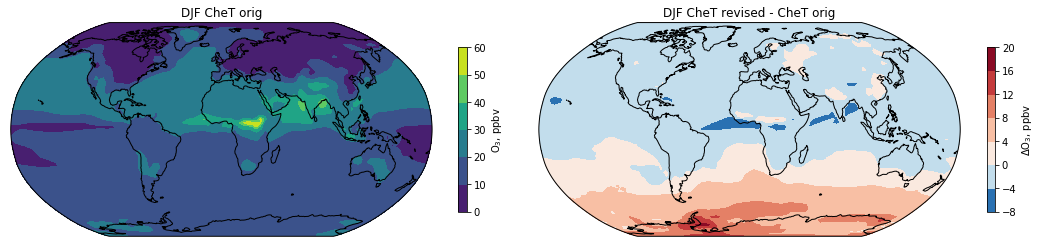

In [25]:
fig, ax = plt.subplots(ncols=2, figsize=(15,6), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)), facecolor='w')
p00 = ax[0].contourf(cyclic_lons, base.coord('latitude').points, cyc_base_srf_djf_mean.data, **srf_mean_cf_kwargs)
ax[0].coastlines()
ax[0].set_global()
ax[0].set_title(f'{str_djf} {base_plt}')
fig.colorbar(p00, ax=ax[0], shrink=0.4, label=f'{str_var}, ppbv')

p01 = ax[1].contourf(cyclic_lons, base.coord('latitude').points, cyc_djf_diff.data, norm=MidpointNormalize(midpoint=0.), **srf_diff_cf_kwargs)
ax[1].scatter(*stipple_srf(srf_djf_diff, srf_djf_p), **srf_pval_sc_kwargs)
ax[1].coastlines()
ax[1].set_global()
ax[1].set_title(f'{str_djf} {sens_plt} - {base_plt}')
fig.colorbar(p01, ax=ax[1], shrink=0.4, label=f'$\Delta${str_var}, ppbv')

fig.tight_layout()
if savefig: fig.savefig(path_to_figs / f'srf_seas_mean_{str_djf}.png', bbox_inches='tight')

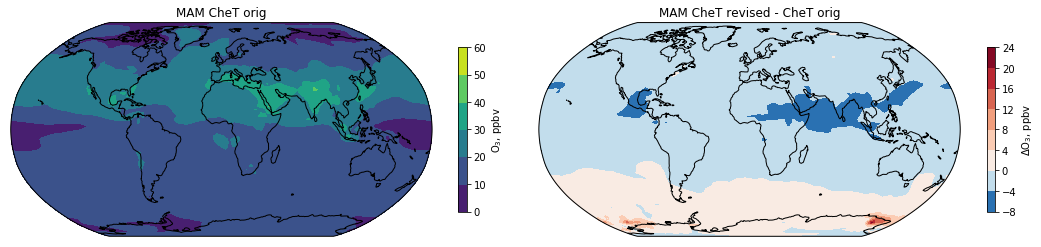

In [26]:
fig, ax = plt.subplots(ncols=2, figsize=(15,6), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)), facecolor='w')
p00 = ax[0].contourf(cyclic_lons, base.coord('latitude').points, cyc_base_srf_mam_mean.data, **srf_mean_cf_kwargs)
ax[0].coastlines()
ax[0].set_global()
ax[0].set_title(f'{str_mam} {base_plt}')
fig.colorbar(p00, ax=ax[0], shrink=0.4, label=f'{str_var}, ppbv')

p01 = ax[1].contourf(cyclic_lons, base.coord('latitude').points, cyc_mam_diff.data, norm=MidpointNormalize(midpoint=0.), **srf_diff_cf_kwargs)
ax[1].scatter(*stipple_srf(srf_mam_diff, srf_mam_p), **srf_pval_sc_kwargs)
ax[1].coastlines()
ax[1].set_global()
ax[1].set_title(f'{str_mam} {sens_plt} - {base_plt}')
fig.colorbar(p01, ax=ax[1], shrink=0.4, label=f'$\Delta${str_var}, ppbv')

fig.tight_layout()
if savefig: fig.savefig(path_to_figs / f'srf_seas_mean_{str_mam}.png', bbox_inches='tight')

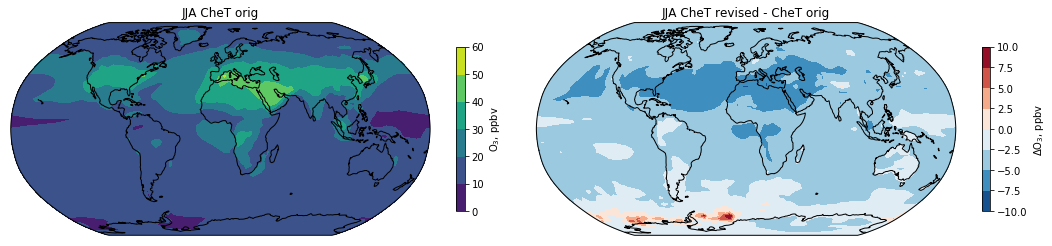

In [27]:
fig, ax = plt.subplots(ncols=2, figsize=(15,6), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)), facecolor='w')
p00 = ax[0].contourf(cyclic_lons, base.coord('latitude').points, cyc_base_srf_jja_mean.data, **srf_mean_cf_kwargs)
ax[0].coastlines()
ax[0].set_global()
ax[0].set_title(f'{str_jja} {base_plt}')
fig.colorbar(p00, ax=ax[0], shrink=0.4, label=f'{str_var}, ppbv')

p01 = ax[1].contourf(cyclic_lons, base.coord('latitude').points, cyc_jja_diff.data, norm=MidpointNormalize(midpoint=0.), **srf_diff_cf_kwargs)
ax[1].scatter(*stipple_srf(srf_jja_diff, srf_jja_p), **srf_pval_sc_kwargs)
ax[1].coastlines()
ax[1].set_global()
ax[1].set_title(f'{str_jja} {sens_plt} - {base_plt}')
fig.colorbar(p01, ax=ax[1], shrink=0.4, label=f'$\Delta${str_var}, ppbv')

fig.tight_layout()
if savefig: fig.savefig(path_to_figs / f'srf_seas_mean_{str_jja}.png', bbox_inches='tight')

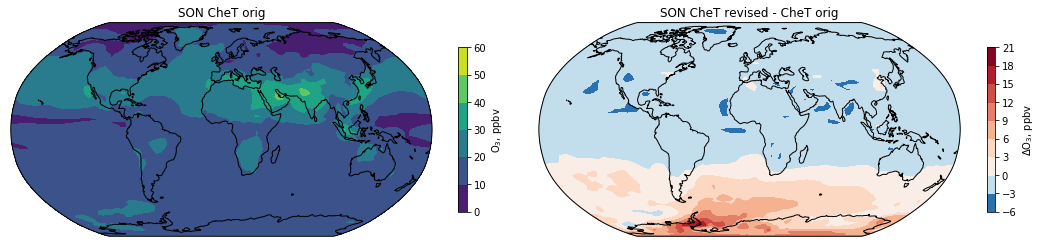

In [28]:
fig, ax = plt.subplots(ncols=2, figsize=(15,6), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)), facecolor='w')
p00 = ax[0].contourf(cyclic_lons, base.coord('latitude').points, cyc_base_srf_son_mean.data, **srf_mean_cf_kwargs)
ax[0].coastlines()
ax[0].set_global()
ax[0].set_title(f'{str_son} {base_plt}')
fig.colorbar(p00, ax=ax[0], shrink=0.4, label=f'{str_var}, ppbv')

p01 = ax[1].contourf(cyclic_lons, base.coord('latitude').points, cyc_son_diff.data, norm=MidpointNormalize(midpoint=0.), **srf_diff_cf_kwargs)
ax[1].scatter(*stipple_srf(srf_son_diff, srf_son_p), **srf_pval_sc_kwargs)
ax[1].coastlines()
ax[1].set_global()
ax[1].set_title(f'{str_son} {sens_plt} - {base_plt}')
fig.colorbar(p01, ax=ax[1], shrink=0.4, label=f'$\Delta${str_var}, ppbv')

fig.tight_layout()
if savefig: fig.savefig(path_to_figs / f'srf_seas_mean_{str_son}.png', bbox_inches='tight')

In [19]:
# # Reference code
# # Reproducing (almost) OConnor2014
# znl_seasonal_mean_levs = [0,20,25,30,35,40,50,60,80,100,500,1000] # almost like in OConnor2014
# znl_seasonal_mean_clrs = ['#5e4fa2','#3288bd','#66c2a5','#abdda4','#e6f598','#ffffbf','#fee08b','#fdae61','#f46d43','#d53e4f','#9e0142']
# znl_seasonal_mean_cmap = mpl.colors.ListedColormap(znl_seasonal_mean_clrs)
# znl_seasonal_mean_cmap.set_over('#7e0034')
# znl_seasonal_mean_norm = mpl.colors.BoundaryNorm(znl_seasonal_mean_levs, znl_seasonal_mean_cmap.N)
# znl_seasonal_mean_kwargs = dict(levels=znl_seasonal_mean_levs, cmap=znl_seasonal_mean_cmap, norm=znl_seasonal_mean_norm, extend='max')

# fig, ax = plt.subplots(figsize=(8,6), facecolor='w')
# p0 = ax.contourf(base.coord('latitude').points, base.coord('level_height').points, base_znl_seasonal_mean.data[0,...],
#                  **znl_seasonal_mean_kwargs)
# ax.set_title(f'{str_djf} {str_var} {base_plt}')
# fig.colorbar(p0, ax=ax, label=f'{str_var}, ppbv', boundaries=znl_seasonal_mean_levs, ticks=znl_seasonal_mean_levs, spacing='uniform')
# ax.set_xlabel('Latitude')
# ax.set_ylabel('Height, km')
# ax.set_ylim(0,20000)
# ax.yaxis.set_major_formatter(FuncFormatter(m2km));

In [20]:
# c2h6
# c3h8
# etono2
# prono2
# etooh
# nprooh
# iprooh
# mecho
# meco2h
# meco3h
# mecoch2ooh